# Group 10 - Process Mining
**Bafoeg-Simulation for Synthetic Data**

# Requires:
pip install -U pm4py
install graphviz


### 1. Importing and Verifying the PM4Py Library

This code imports **PM4Py**, a Python library for **process mining**, which is commonly used to analyze event logs, discover process models, and perform conformance checking.

The second line prints the currently installed **PM4Py version**, which is useful for:


In [90]:
import pm4py
import graphviz
print(pm4py.__version__)

2.7.19.2


### 3. Importing PM4Py Modules for Conformance Checking and Simulation

These imports prepare PM4Py functionality for **(1) conformance checking** using alignments and **(2) Petri net simulation (playout)**.

In [91]:
from pm4py.algo.simulation.montecarlo import algorithm as montecarlo_simulator
from pm4py.objects.random_variables.normal.random_variable import Normal
from pm4py.objects.random_variables.uniform.random_variable import Uniform
from pm4py.objects.random_variables.exponential.random_variable import Exponential
from pm4py.objects.log.obj import EventLog
import pm4py
import random
from pm4py.objects.log.obj import EventLog

### 2. Loading a BPMN Model and Listing Its Nodes

This code reads a **BPMN (.bpmn) file** into a PM4Py BPMN object, extracts all nodes (e.g., tasks, events, gateways), and prints each node’s **Python class/type** and its **BPMN label/name**.



In [92]:
bpmn = pm4py.read_bpmn("group_10.bpmn")
nodes = bpmn.get_nodes()
net, im, fm = pm4py.convert_to_petri_net(bpmn)

## 0. AKTIVITÄTEN-KONFIGURATION (Role + Duration)

In [ ]:
activity_config = {
    # Clerk (Sachbearbeiter) - Manuelle Tätigkeiten
    'ReviewDocuments': {
        'role': 'Clerk',
        'duration': Normal(mu=420, sigma=60),  # 7 Min ± 60s
        'weight': 1.0
    },
    'Store Application': {
        'role': 'Clerk',
        'duration': Normal(mu=120, sigma=30),  # 2 minuten +- 30s
        'weight': 0.6
    },
    'RequestResubmission': {
        'role': 'Clerk',
        'duration': Uniform(loc=60, scale=120),  # 1-3 Min
        'weight': 0.4
    },
    'Assess Application': {
        'role': 'Clerk',
        'duration': Normal(mu=600, sigma=120),  # 10 Min ± 2 Min
        'weight': 1.0
    },
    'Calculate Claim': {
        'role': 'Clerk',
        'duration': Normal(mu=900, sigma=100),  # 15 Min ± 100s
        # Beispiel: 80% gehen in "Calculate Claim" vs. 30% "Write Rejection"
        'weight': 0.8
    },
    'Write Rejection': {
        'role': 'Clerk',
        'duration': Normal(mu=180, sigma=30),  # 3 Min ± 30s
        'weight': 0.2
    },
    'Write Notification': {
        'role': 'Clerk',
        'duration': Normal(mu=180, sigma=30),  # 3 Min ± 30s
        'weight': 1.0
    },
    'Send Notification': {
        'role': 'Clerk',
        'duration': Uniform(loc=60, scale=90),  # 1 Min
        'weight': 1.0
    },
    'Send Rejection': {
        'role': 'Clerk',
        'duration': Uniform(loc=60, scale=90),  # 1 Min
        'weight': 1.0
    },
    
    # System - Automatisierte Tätigkeiten
    'Send Mail To Parents': {
        'role': 'System',
        'duration': Uniform(loc=1, scale=2),  # 1-3 Sek
        'weight': 0.9
    },
    'Receive Parents Data': {
        'role': 'System',
        'duration': Exponential(loc=0, scale=345600),  # Ø 4 Tage Wartezeit bis Eltern Daten schicken
        'weight': 1.0
    },
    'Generate Confirmation Mail': {
        'role': 'System',
        'duration': Uniform(loc=2, scale=3),  # 2-5 Sek
        'weight': 0.1
    },
    'Send Confirmation Mail': {
        'role': 'System',
        'duration': Uniform(loc=1, scale=2),  # 1-3 Sek
        'weight': 1.0
    },

    # Auf System gestellt (obwohl eigentlich Clerk-Tätigkeit) -> vermeidet das Problem, dass Clerks nichts zu tun können, solange sie auf eine Resubmission warten (wäre ja quatsch)
    'ReceiveResubmission': {
        'role': 'System',
        'duration': Exponential(loc=0, scale=345600),  # Ø 4 Tage Wartezeit bis Eltern Daten schicken
        'weight': 1.0
    },
}

## 1. STOCHASTIC MAP - aus activity_config extrahieren

In [94]:
from pm4py.objects.random_variables.random_variable import RandomVariable

# Build smap with pm4py RandomVariable objects (required by the simulator)
smap = {}

# helper to attach a weight API expected by pick_transition()
# supports: numeric weights, pm4py random variables, or callables returning a float

def _make_weight_getter(weight):
    # pm4py RandomVariable wrappers often store the actual rv in 'random_variable'
    inner = getattr(weight, 'random_variable', weight)

    # callable provided by user
    if callable(weight):
        return lambda: float(weight())

    # distribution with common sampling APIs
    for attr in ("rvs", "sample", "get_value"):
        fn = getattr(inner, attr, None)
        if callable(fn):
            return lambda fn=fn: float(fn())

    # fallback: treat as constant numeric
    try:
        val = float(weight)
        return lambda val=val: val
    except Exception:
        # last resort: constant 1.0
        return lambda: 1.0


def _attach_weight(obj, weight):
    # monkey-patch: ensure smap[transition] has a get_weight() accessor
    gw = _make_weight_getter(weight)
    setattr(obj, "get_weight", gw)
    return obj

for transition in net.transitions:
    # Wenn in activity_config bereits ein RandomVariable-Objekt steht,
    # verwende dieses direkt als Wert für smap (kein Rekonstruieren).
    label = transition.label
    if label and label in activity_config:
        rv = activity_config[label]['duration']
        w = activity_config[label].get('weight', 1.0)
        smap[transition] = _attach_weight(rv, w)
    else:
        # Silent / default: sehr kleine Verzögerung
        rv = RandomVariable()
        rv.read_from_string('UNIFORM', '0.001;0.1')
        smap[transition] = _attach_weight(rv, 1.0)

print(smap)

{(Activity_1anmjnd, 'Assess Application'): NORMAL 600;120, (Activity_0pvdge2, 'Write Notification'): NORMAL 180;30, (Activity_02rdnqd, 'ReviewDocuments'): NORMAL 420;60, (7670ce0c-f19a-41f7-a8cb-5e80018ddd65, None): UNIFORM 0.001;0.1, (Activity_11ljlt8, 'Send Notification'): UNIFORM 60;90, (Activity_031corn, 'Receive Parents Data'): EXPONENTIAL 2.8935185185185184e-06, (Gateway_0bw7r2t, None): UNIFORM 0.001;0.1, (Activity_1lip6o3, 'Write Rejection'): NORMAL 180;30, (Activity_1reuwa9, 'Store Application'): NORMAL 120;30, (Activity_1sghd3e, 'Send Confirmation Mail'): UNIFORM 1;2, (Activity_1rula96, 'RequestResubmission'): UNIFORM 60;120, (Activity_0na27kh, 'ReceiveResubmission'): EXPONENTIAL 2.8935185185185184e-06, (Activity_12go9h5, 'Send Rejection'): UNIFORM 60;90, (Activity_0vtb6uj, 'Generate Confirmation Mail'): UNIFORM 2;3, (Activity_0dbquyc, 'Send Mail To Parents'): UNIFORM 1;2, (Activity_0ir0f2q, 'Calculate Claim'): NORMAL 900;100, (sfl_Flow_06dhjwd, None): UNIFORM 0.001;0.1}


In [95]:
# --- Normalize numeric attributes inside smap values to avoid string dtypes ---
def _normalize_rv_obj(obj):
    # obj can be pm4py RandomVariable wrapper or a distribution object
    inner = getattr(obj, 'random_variable', obj)
    for attr in ('loc', 'scale', 'mu', 'sigma'):
        if hasattr(inner, attr):
            val = getattr(inner, attr)
            if isinstance(val, str):
                try:
                    setattr(inner, attr, float(val))
                except Exception:
                    print(f"WARN: cannot convert {attr}='{val}' to float for {inner}")

for k, v in list(smap.items()):
    _normalize_rv_obj(v)

print(smap)

{(Activity_1anmjnd, 'Assess Application'): NORMAL 600;120, (Activity_0pvdge2, 'Write Notification'): NORMAL 180;30, (Activity_02rdnqd, 'ReviewDocuments'): NORMAL 420;60, (7670ce0c-f19a-41f7-a8cb-5e80018ddd65, None): UNIFORM 0.001;0.1, (Activity_11ljlt8, 'Send Notification'): UNIFORM 60;90, (Activity_031corn, 'Receive Parents Data'): EXPONENTIAL 2.8935185185185184e-06, (Gateway_0bw7r2t, None): UNIFORM 0.001;0.1, (Activity_1lip6o3, 'Write Rejection'): NORMAL 180;30, (Activity_1reuwa9, 'Store Application'): NORMAL 120;30, (Activity_1sghd3e, 'Send Confirmation Mail'): UNIFORM 1;2, (Activity_1rula96, 'RequestResubmission'): UNIFORM 60;120, (Activity_0na27kh, 'ReceiveResubmission'): EXPONENTIAL 2.8935185185185184e-06, (Activity_12go9h5, 'Send Rejection'): UNIFORM 60;90, (Activity_0vtb6uj, 'Generate Confirmation Mail'): UNIFORM 2;3, (Activity_0dbquyc, 'Send Mail To Parents'): UNIFORM 1;2, (Activity_0ir0f2q, 'Calculate Claim'): NORMAL 900;100, (sfl_Flow_06dhjwd, None): UNIFORM 0.001;0.1}


# 2. RESSOURCEN-MAP (über Arcs analysieren)

In [96]:
sim_options = {
    'clerk_amount': 20,
    'system_amout': 9999
}
resources_per_place = {}

# Erstelle Mapping: Transition → Role
transition_to_role = {}
for transition in net.transitions:
    if transition.label in activity_config:
        transition_to_role[transition] = activity_config[transition.label]['role']

# Für jeden Place: schaue wohin er zeigt (welche Transitions er füttert)
for place in net.places:
    # Finde alle Arcs von diesem Place zu Transitions
    outgoing_transitions = []
    for arc in net.arcs:
        if hasattr(arc, 'source') and hasattr(arc, 'target'):
            # Arc geht von diesem Place zu einer Transition
            if arc.source == place and arc.target in net.transitions:
                outgoing_transitions.append(arc.target)
    
    # Prüfe ob irgendeine Ziel-Transition eine Clerk-Activity ist
    feeds_clerk = False
    for transition in outgoing_transitions:
        if transition_to_role.get(transition) == 'Clerk':
            feeds_clerk = True
            break
    
    # Ressourcen zuweisen
    if feeds_clerk:
        resources_per_place[place] = sim_options['clerk_amount']  # 20 Clerks
    else:
        resources_per_place[place] = sim_options['system_amout']  # 9999 System/unbegrenzt

print("\nRessourcen-Dict:", resources_per_place)


Ressourcen-Dict: {ent_Activity_0na27kh: 9999, ent_Activity_1sghd3e: 9999, exi_Gateway_0j17y0t: 20, exi_Gateway_0wbr4r3: 20, ent_Activity_0pvdge2: 20, ent_Activity_1anmjnd: 20, ent_Activity_031corn: 9999, ent_Gateway_0amxybm: 9999, ent_Activity_12go9h5: 20, source: 9999, ent_Gateway_1ctv541: 20, sink: 9999, ent_Gateway_0bw7r2t: 9999, exi_Gateway_142a9j9: 9999, ent_Activity_11ljlt8: 20}


## 3. SIMULATION DURCHFÜHREN

In [97]:
parameters = {
    'num_simulations': 2000,
    # kann noch optimiert werden mit exponential-verteilung
    'case_arrival_ratio': 36.0,
    'provided_stochastic_map': smap,
    'map_resources_per_place': resources_per_place,
    'default_num_resources_per_place': 1,
    'enable_diagnostics': True,
    'diagn_interval': 32,
    'small_scale_factor': 1.0,
    'max_thread_execution_time': 7200.0
}
empty_log = EventLog()

print("\n=== Starte Monte Carlo Simulation ===")
print(f"Simuliere {parameters['num_simulations']} Cases")
print(f"Case Arrival: alle {parameters['case_arrival_ratio']} Sekunden")
print(f"Ressourcen-Constraints: {len([r for r in resources_per_place.values() if r < 100])} Places mit Limits")

simulated_log, diagnostics = montecarlo_simulator.apply(
    empty_log, 
    net, 
    im, 
    fm,
    parameters=parameters
)


=== Starte Monte Carlo Simulation ===
Simuliere 2000 Cases
Case Arrival: alle 36.0 Sekunden
Ressourcen-Constraints: 7 Places mit Limits


# 5. ROLLEN ZU EVENTS HINZUFÜGEN

In [98]:
clerk_amount = sim_options['clerk_amount'] + 1
clerk_pool = [f'Clerk_{i}' for i in range(1, clerk_amount)]

for trace in simulated_log:
    # EINEN Clerk pro Case zuweisen
    assigned_clerk = random.choice(clerk_pool)
    
    for event in trace:
        activity_name = event['concept:name']
        config = activity_config.get(activity_name)
        
        if config:
            role = config['role']
            event['org:role'] = role
            
            if role == 'Clerk':
                event['org:resource'] = assigned_clerk  # Gleicher Clerk für ganzen Case
            elif role == 'System':
                event['org:resource'] = 'BafoegDigital'

print(trace[:5])
# Log speichern
pm4py.write_xes(simulated_log, 'bafoeg_simulation.xes')
print(f"\nLog gespeichert als 'bafoeg_simulation.xes'")

[{'concept:name': 'Generate Confirmation Mail', 'time:timestamp': datetime.datetime(1970, 1, 13, 10, 46, 6, 154664, tzinfo=datetime.timezone.utc), 'org:role': 'System', 'org:resource': 'BafoegDigital'}, {'concept:name': 'Send Confirmation Mail', 'time:timestamp': datetime.datetime(1970, 1, 13, 10, 46, 8, 396802, tzinfo=datetime.timezone.utc), 'org:role': 'System', 'org:resource': 'BafoegDigital'}, {'concept:name': 'ReviewDocuments', 'time:timestamp': datetime.datetime(1970, 1, 13, 10, 52, 16, 83174, tzinfo=datetime.timezone.utc), 'org:role': 'Clerk', 'org:resource': 'Clerk_7'}, {'concept:name': 'RequestResubmission', 'time:timestamp': datetime.datetime(1970, 1, 13, 10, 54, 4, 207964, tzinfo=datetime.timezone.utc), 'org:role': 'Clerk', 'org:resource': 'Clerk_7'}, {'concept:name': 'ReceiveResubmission', 'time:timestamp': datetime.datetime(1970, 1, 14, 14, 40, 36, 306820, tzinfo=datetime.timezone.utc), 'org:role': 'System', 'org:resource': 'BafoegDigital'}]


exporting log, completed traces ::   0%|          | 0/2000 [00:00<?, ?it/s]


Log gespeichert als 'bafoeg_simulation.xes'


# 6. ERGEBNISSE ANALYSIEREN

In [99]:
from pm4py.statistics.traces.generic.log import case_statistics
from pm4py.statistics.attributes.log import get as attributes_get
from pm4py.util import constants

print(f"\n=== Simulationsergebnisse ===")

# Case Statistics
all_durations = case_statistics.get_all_case_durations(
    simulated_log,
    parameters={constants.PARAMETER_CONSTANT_TIMESTAMP_KEY: 'time:timestamp'}
)
median_duration = case_statistics.get_median_case_duration(
    simulated_log,
    parameters={constants.PARAMETER_CONSTANT_TIMESTAMP_KEY: 'time:timestamp'}
)

print(f"Cases: {len(simulated_log)}")
print(f"Durchlaufzeit - Min: {min(all_durations)/3600:.1f}h, Median: {median_duration/3600:.1f}h, Max: {max(all_durations)/3600:.1f}h")

# Activity Frequencies
activities = attributes_get.get_attribute_values(simulated_log, 'concept:name')
rejection_count = activities.get('Write Rejection', 0)
calculation_count = activities.get('Calculate Claim', 0)

print(f"\nEntscheidungen: Accepted {calculation_count} ({calculation_count/len(simulated_log)*100:.0f}%), Rejected {rejection_count} ({rejection_count/len(simulated_log)*100:.0f}%)")

# Resource Workload
resources = attributes_get.get_attribute_values(simulated_log, 'org:resource')
clerk_total = sum(count for res, count in resources.items() if 'Clerk' in res)
system_total = resources.get('BafoegDigital', 0)

print(f"Workload: Clerk {clerk_total} ({clerk_total/(clerk_total+system_total)*100:.0f}%), System {system_total} ({system_total/(clerk_total+system_total)*100:.0f}%)")


=== Simulationsergebnisse ===
Cases: 2000
Durchlaufzeit - Min: 0.3h, Median: 46.5h, Max: 1158.9h

Entscheidungen: Accepted 1602 (80%), Rejected 398 (20%)
Workload: Clerk 14348 (67%), System 7053 (33%)


### 5. Discovering a Petri Net from an Event Log (Inductive Miner) and Visualizing It
This repeats the model-discovery step using **Inductive Miner** to derive a **Petri net** from the event log (`log`). The output is a new, discovered process model (`net_d`) with its start and end states (`im_d`, `fm_d`).
The visualization call then renders the discovered Petri net so you can inspect the structure (places, transitions, paths, and potential loops).  

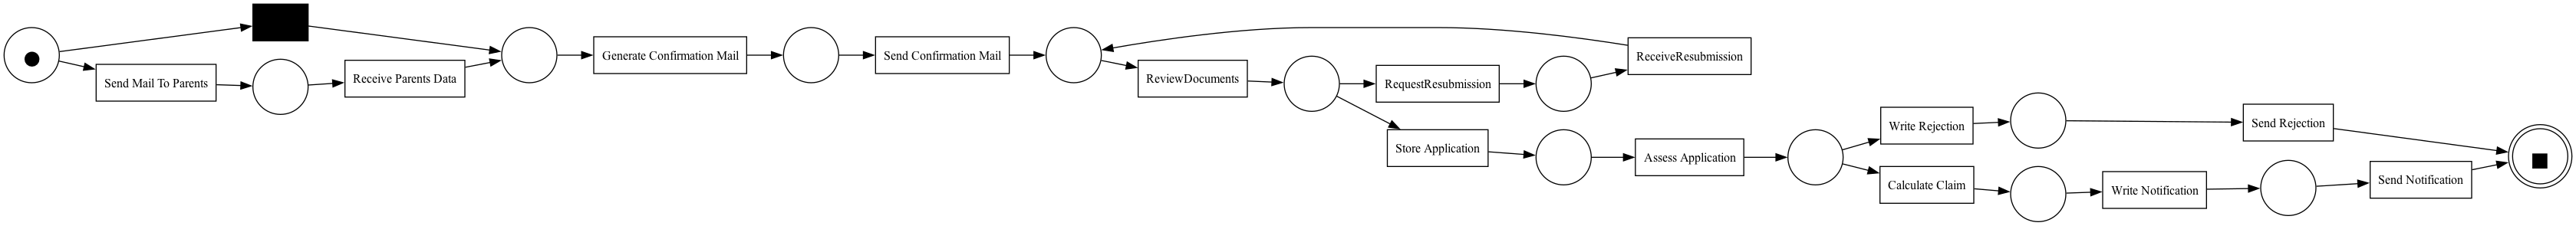

In [100]:
from pm4py import discover_petri_net_inductive
net_d, im_d, fm_d = discover_petri_net_inductive(simulated_log)
pm4py.view_petri_net(net_d, im_d, fm_d)

### 6. Checking Which Model Transitions Actually Appear in the Simulated Log

This section compares the **activities recorded in the event log** with the **labeled transitions in the Petri net** to detect parts of the model that were **never executed** during simulation.

What it does:
- **Counts activities in the log:**  
  Uses `Counter` to count how often each event name (`"concept:name"`) appears across all traces.
- **Lists labeled transitions in the Petri net:**  
  Iterates over `net.transitions` and prints only transitions that have a `label` (i.e., real activities; unlabeled transitions are often silent/τ transitions).
- **Finds transitions never seen in the log:**  
  Prints transitions that exist in the model but whose labels do not appear in the log activity counts.  
  This is useful to spot:
  - paths that are rarely/never taken due to simulation settings,
  - dead branches caused by modeling issues,
  - behavior excluded by trace length limits or randomness in playout.


In [101]:
from collections import Counter

# activities that appear in the simulated log
acts_in_log = Counter(e["concept:name"] for trace in simulated_log for e in trace)
print("Activities in log (and counts):")
for a, c in acts_in_log.items():
    print(c, "x", a)

# all labeled transitions in the Petri net
print("\nTransitions in Petri net:")
for t in net.transitions:
    if t.label:
        print(t.label)

print("\nTransitions never seen in log:")
for t in net.transitions:
    if t.label and t.label not in acts_in_log:
        print("  ", t.label)

Activities in log (and counts):
2000 x Generate Confirmation Mail
2000 x Send Confirmation Mail
3373 x ReviewDocuments
2000 x Store Application
2000 x Assess Application
1602 x Calculate Claim
1602 x Write Notification
1602 x Send Notification
840 x Send Mail To Parents
840 x Receive Parents Data
1373 x RequestResubmission
1373 x ReceiveResubmission
398 x Write Rejection
398 x Send Rejection

Transitions in Petri net:
Assess Application
Write Notification
ReviewDocuments
Send Notification
Receive Parents Data
Write Rejection
Store Application
Send Confirmation Mail
RequestResubmission
ReceiveResubmission
Send Rejection
Generate Confirmation Mail
Send Mail To Parents
Calculate Claim

Transitions never seen in log:


### 7. Exporting the Simulated Event Log to an XES File

This line writes the simulated event log (`log`) to disk in **XES format**, which is the standard file format used in process mining tools (including PM4Py, ProM, Celonis imports in some workflows, etc.).

Use cases:
- Saving the generated traces for reuse without re-simulating
- Sharing the log with teammates or importing it into other process-mining tools
- Running discovery/conformance experiments on a fixed dataset


In [102]:
# Generate XES file from the simulated log (Event Log)
log = pm4py.write_xes(simulated_log, "simulated_log_Initially.xes")

exporting log, completed traces ::   0%|          | 0/2000 [00:00<?, ?it/s]

### 8. POST Processing of XES Log to get realistic Event Attributes like Timestamp, Resource etc.

### Shifting All Timestamps in an XES Log to Start in 2024

This block loads an existing **XES event log**, detects the **earliest timestamp** in the log (often around 1970 when simulated logs start at the Unix epoch), and shifts **all event timestamps** forward so the log begins at a chosen reference date in **2024**. The updated log is then exported to a new XES file.

What it does:
- **Imports** the log from `INPUT_XES`.
- **Finds the global minimum timestamp** (`min_ts`) across all events in all traces.
- **Defines a new start time** (`base_2024`) as `2024-01-01 08:00:00`, using the *same timezone info* as the original timestamps to avoid tz-aware vs tz-naive issues.
- **Computes an offset** (`base_2024 - min_ts`) and applies it to every event timestamp.
- **Exports** the shifted log to `OUTPUT_XES` and prints the output filename.

Why this is useful:
- Makes simulated logs look like realistic, modern process data.
- Avoids confusing “1970 timestamps” when importing into tools or doing time-based analysis (durations, calendars, seasonality, etc.).


In [103]:
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.log.exporter.xes import exporter as xes_exporter
from datetime import datetime, timedelta

INPUT_XES  = "simulated_log_Initially.xes"
OUTPUT_XES = "simulated_log_2024_shifted.xes"

log = xes_importer.apply(INPUT_XES)

# find global min timestamp (1970…)
min_ts = None
for trace in log:
    for event in trace:
        ts = event["time:timestamp"]
        if min_ts is None or ts < min_ts:
            min_ts = ts

# make base_2024 timezone-aware with same tzinfo as min_ts
base_2024 = datetime(2024, 9, 15, 0, 0, 0, tzinfo=min_ts.tzinfo)

offset = base_2024 - min_ts

print(offset)

for trace in log:
    for event in trace:
        old_ts = event["time:timestamp"]
        event["time:timestamp"] = old_ts + offset

xes_exporter.apply(log, OUTPUT_XES)
print("written:", OUTPUT_XES)


parsing log, completed traces ::   0%|          | 0/2000 [00:00<?, ?it/s]

19969 days, 9:13:17.062061


exporting log, completed traces ::   0%|          | 0/2000 [00:00<?, ?it/s]

written: simulated_log_2024_shifted.xes


- TODO More postporcessing following the guidlines G1-12 from the book
- TODO Object Centric? 
- TODO Exponentialverteilung integrieren (aktuell 32 Anfragen pro Sek - statisch)
- TODO Verfügbarkeitszeiten? - BafoegAmt von 6-16 z.b